# Weather Time Series Strategy Notebook


## Our goals:
- Optimise Energy Consumption: Knowing the hours of sunshine and solar irradiation helps us manage our energy reserves efficiently- the car output power is mostly depends on the solar irradiation levels.
- Enhance Vehicle Design: Make data driven desicions while building the car 
- Adjust strategies dynamically based on high-risk conditions (e.g., unexpected cloud cover).
- Make a 24h GHI prediction as an input parameters to the car simulation.

### TODO:
- Update csv utc, date and time

- Split data into train and test

- Create a prediction model (probably LSTM) for a 24h race (approx. 16-22 september 2026)
- Export the 24h hour predicted model distribution as a csv to our simulator

## Data collection method
By using solcast API, we managed to collect weather and irradiance data from the circuit zolder route location, the data collected in intervals of 5 minutes and using UTC time format.

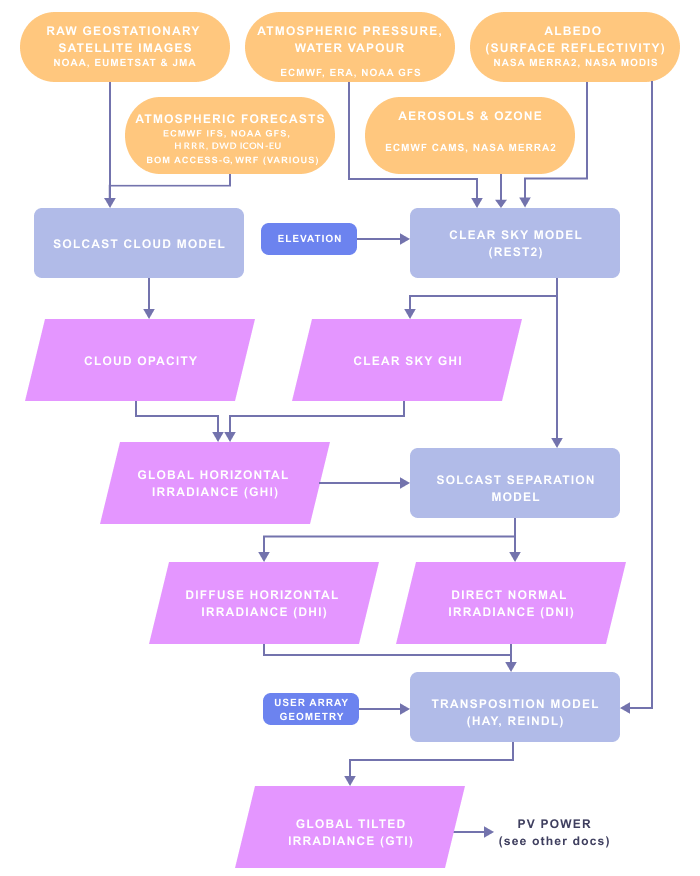

### The chosen features:
1. **GHI** - "Global Horizontal Irradiance" refers to the total solar radiation received per unit area on a horizontal surface, which helps estimate how much energy is available from all incoming solar radiation, including diffuse sunlight, which can affect the car even when it's not directly facing the sun. `(W/m²)`  
2. **DNI** - "Direct Normal Irradiance" represents the quantity of radiation received per unit area on a surface perpendicular to the sun. `(W/m²)`
3. **cloud_opacity** - Indicates how much sunlight is blocked by clouds. `(%)`
4. **Air_temp** - Calculated 2m above ground level, Affects solar car efficiency, battery performance and cooling needs. `Celsius (°C)`
5. **Wind Speed (10m)** - Relevant for aerodynamic drag and car speed optimization. `Meters per second (m/s)`
6. **Wind direction (10m)**  - See #5. `Degrees (°)`
7. **Clearsky_DNI** -  additional optimal scenario data. `(W/m²)`
8. **Clearsky_GHI** - See #7. `(W/m²)`
9. **Percipitable_water** - Percipitable water can absorb incoming solar radiation at the atmosphere. `Millimeters (mm)`
10. **Percipitation_rate** - Affects the chance of rain, and indicates the rate of change to #9.` Millimeters per hour (mm/h)`


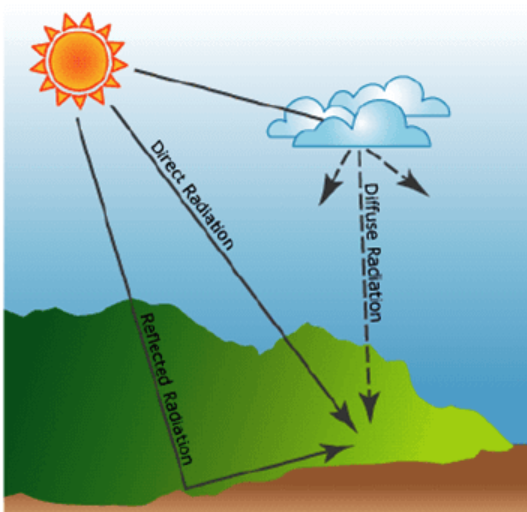

In [21]:
# notebook imports
import pandas as pd
from datetime import datetime
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [22]:
# Initialize an empty list to store DataFrames
dfs = []

# Loop through the years and read the CSV files
for i in range(2014, 2025):
    df_temp = pd.read_csv(f'/kaggle/input/weather-data/Data/{i}/{i}.csv')
    df_temp = df_temp.drop(columns=['period'])
    dfs.append(df_temp)

# Concatenate all DataFrames in the list
df = pd.concat(dfs, ignore_index=True)

# Display the DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91872 entries, 0 to 91871
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp            91872 non-null  int64  
 1   clearsky_dni        91872 non-null  int64  
 2   clearsky_ghi        91872 non-null  int64  
 3   cloud_opacity       91872 non-null  float64
 4   dni                 91872 non-null  int64  
 5   ghi                 91872 non-null  int64  
 6   precipitable_water  91872 non-null  float64
 7   precipitation_rate  91872 non-null  float64
 8   wind_direction_10m  91872 non-null  int64  
 9   wind_speed_10m      91872 non-null  float64
 10  period_end          91872 non-null  object 
dtypes: float64(4), int64(6), object(1)
memory usage: 7.7+ MB


### As we can see, there is no empty cells in our dataset

In [23]:
df.describe()

,air_temp,clearsky_dni,clearsky_ghi,cloud_opacity,dni,ghi,precipitable_water,precipitation_rate,wind_direction_10m,wind_speed_10m
count,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000,91872.000000
mean,15.170367,305.275688,191.257032,31.197032,135.792091,132.856616,22.625328,0.098785,187.789141,3.227190
std,4.486312,343.095779,240.391061,31.982306,262.328472,191.354002,6.828265,0.362082,84.570232,1.619955
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.400000,0.000000,124.000000,2.000000
50%,15.000000,8.000000,7.000000,23.100000,0.000000,3.000000,21.600000,0.000000,206.000000,2.900000
75%,18.000000,684.000000,418.000000,58.400000,79.000000,221.000000,27.000000,0.000000,243.000000,4.100000
max,34.000000,910.000000,730.000000,97.000000,910.000000,729.000000,50.000000,6.900000,360.000000,11.300000


In [24]:
df.sample(5)

,air_temp,clearsky_dni,clearsky_ghi,cloud_opacity,dni,ghi,precipitable_water,precipitation_rate,wind_direction_10m,wind_speed_10m,period_end
90211,4,0,0,0.0,0,0,12.3,0.0,168,1.9,2024-09-29T05:40:00+00:00
51008,17,0,0,42.0,0,0,36.9,0.0,219,2.8,2020-09-09T02:45:00+00:00
27085,13,0,0,70.8,0,0,29.1,0.8,196,8.7,2017-09-13T01:10:00+00:00
58750,14,0,0,38.4,0,0,30.2,0.0,136,1.9,2021-09-06T23:55:00+00:00
89369,16,687,252,70.4,0,74,23.7,0.0,217,5.6,2024-09-26T07:30:00+00:00


 Some conversion (UTC to local time) is needed..

In [25]:
# Converting UTC to the circuit zolder local time
target_timezone = pytz.timezone('Europe/Brussels')

def convert_to_local_time(utc_time_str):
    utc_time = datetime.fromisoformat(utc_time_str)  
    local_time = utc_time.astimezone(target_timezone)
    return local_time

df['local_time'] = df['period_end'].apply(convert_to_local_time)
df = df.drop(columns=['period_end'])

In [26]:
# Convert 'local_time' to datetime format
df['local_time'] = pd.to_datetime(df['local_time'])

# Extracting the date and time from 'local_time'
df['date'] = df['local_time'].dt.date
df['time'] = df['local_time'].dt.time

# Dropping the original 'local_time' column
df = df.drop(columns=['local_time'])

In [27]:
df.value_counts('time')

time
20:40:00    319
20:45:00    319
20:50:00    319
20:55:00    319
21:00:00    319
           ... 
00:15:00    319
00:20:00    319
00:25:00    319
00:30:00    319
00:35:00    319
Name: count, Length: 288, dtype: int64

### Split time and date into seperate columns

In [28]:
# split time into hours and minutes
df['hour'] = df['time'].apply(lambda x: x.hour)
df['minute'] = df['time'].apply(lambda x: x.minute)
df = df.drop(columns=['time'])

In [29]:
#split date into year, day
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df = df.drop(columns=['date'])
df.sample(5)

,air_temp,clearsky_dni,clearsky_ghi,cloud_opacity,dni,ghi,precipitable_water,precipitation_rate,wind_direction_10m,wind_speed_10m,hour,minute,year,month,day
81270,11,0,0,15.2,0,0,22.5,0.0,174,1.8,6,35,2023,9,27
37545,20,710,451,0.0,710,451,26.9,0.0,215,4.9,10,50,2018,9,20
7770,13,0,0,0.0,0,0,27.4,0.0,125,1.8,1,35,2014,10,3
23407,16,440,111,0.0,440,111,21.2,0.0,212,5.6,8,40,2016,9,29
86250,17,796,654,9.2,567,593,22.6,0.0,302,1.8,13,35,2024,9,15


In [30]:
# delete all rows with date 05/10 as its not a full 24h day in the dataset
df = df[df['day'] != 5]

In [31]:
# convert ghi, dni, clearsky_dni, clearsky_ghi to kwh/M^2
df['ghi'] = df['ghi'] / 1000

### Next we will show some data visualizations:
- Avg GHI 24h distribution per hour per year (kWh/m^2) 
- Avg GHI per day per year (kWh/m^2)
- cloud_opacity 24h avg distribution bar plot
- wind direction + speed patterns 
- air_temp 24h avg distribution bar plot
- percipitation rate and percitipation water avg distribution over 24h

**(kWh = (watts × hrs) ÷ 1,000)**

In [32]:
def calculate_hourly_avg_ghi_per_year(df, year):
    df_year = df[df['year'] == year]
    ghi_avg = df_year.groupby(['hour'])['ghi'].mean().reset_index()
    return ghi_avg

In [33]:
def plot_hourly_avg_ghi_per_year(ghi_avg, year, ax, y_limits):
    # Plotting the bar chart on the specific axis (ax)
    sns.barplot(data=ghi_avg, x='hour', y='ghi', color='lightblue', edgecolor='black', ax=ax)

    # Overlaying a line plot to show the trend
    ax.plot(ghi_avg['hour'], ghi_avg['ghi'], color='darkblue', marker='o', linestyle='-', linewidth=2, markersize=6)

    # Adding title and labels
    ax.set_title(f'Hourly Average GHI in {year}', fontsize=14)
    ax.set_xlabel('Hour', fontsize=12)
    ax.set_ylabel('GHI (kWh/m²)', fontsize=12)

    # Adding gridlines for better visual separation
    ax.grid(True, linestyle='--')

    # Customizing x-ticks to show hours in "HH:MM" format (e.g., "00:00", "01:00")
    xticks = pd.date_range('00:00', '23:00', freq='h').strftime('%H:%M')
    ax.set_xticks(range(24))
    ax.set_xticklabels(xticks, fontsize=8, rotation=45)

    # Setting the same Y-axis scale for all subplots
    ax.set_ylim(y_limits)

In [34]:
def plot_all_years(df, start_year=2015, end_year=2024):
    # Create a 5x2 grid of subplots for years 2015 to 2024
    fig, axes = plt.subplots(5, 2, figsize=(20, 20))  # 5 rows, 2 columns
    axes = axes.flatten()  # Flatten to easily index the axes

    # Determine the global Y-axis limits across all years
    global_min = float('inf')
    global_max = float('-inf')

    for year in range(start_year, end_year + 1):
        ghi_avg = calculate_hourly_avg_ghi_per_year(df, year)
        global_min = min(global_min, ghi_avg['ghi'].min())
        global_max = max(global_max, ghi_avg['ghi'].max()+0.05)

    y_limits = (global_min, global_max)

    for i, year in enumerate(range(start_year, end_year + 1)):
        # Calculate the hourly average for each year
        ghi_avg = calculate_hourly_avg_ghi_per_year(df, year)
        # Plot the hourly average GHI for the specific year on the subplot
        plot_hourly_avg_ghi_per_year(ghi_avg, year, axes[i], y_limits)

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.show()

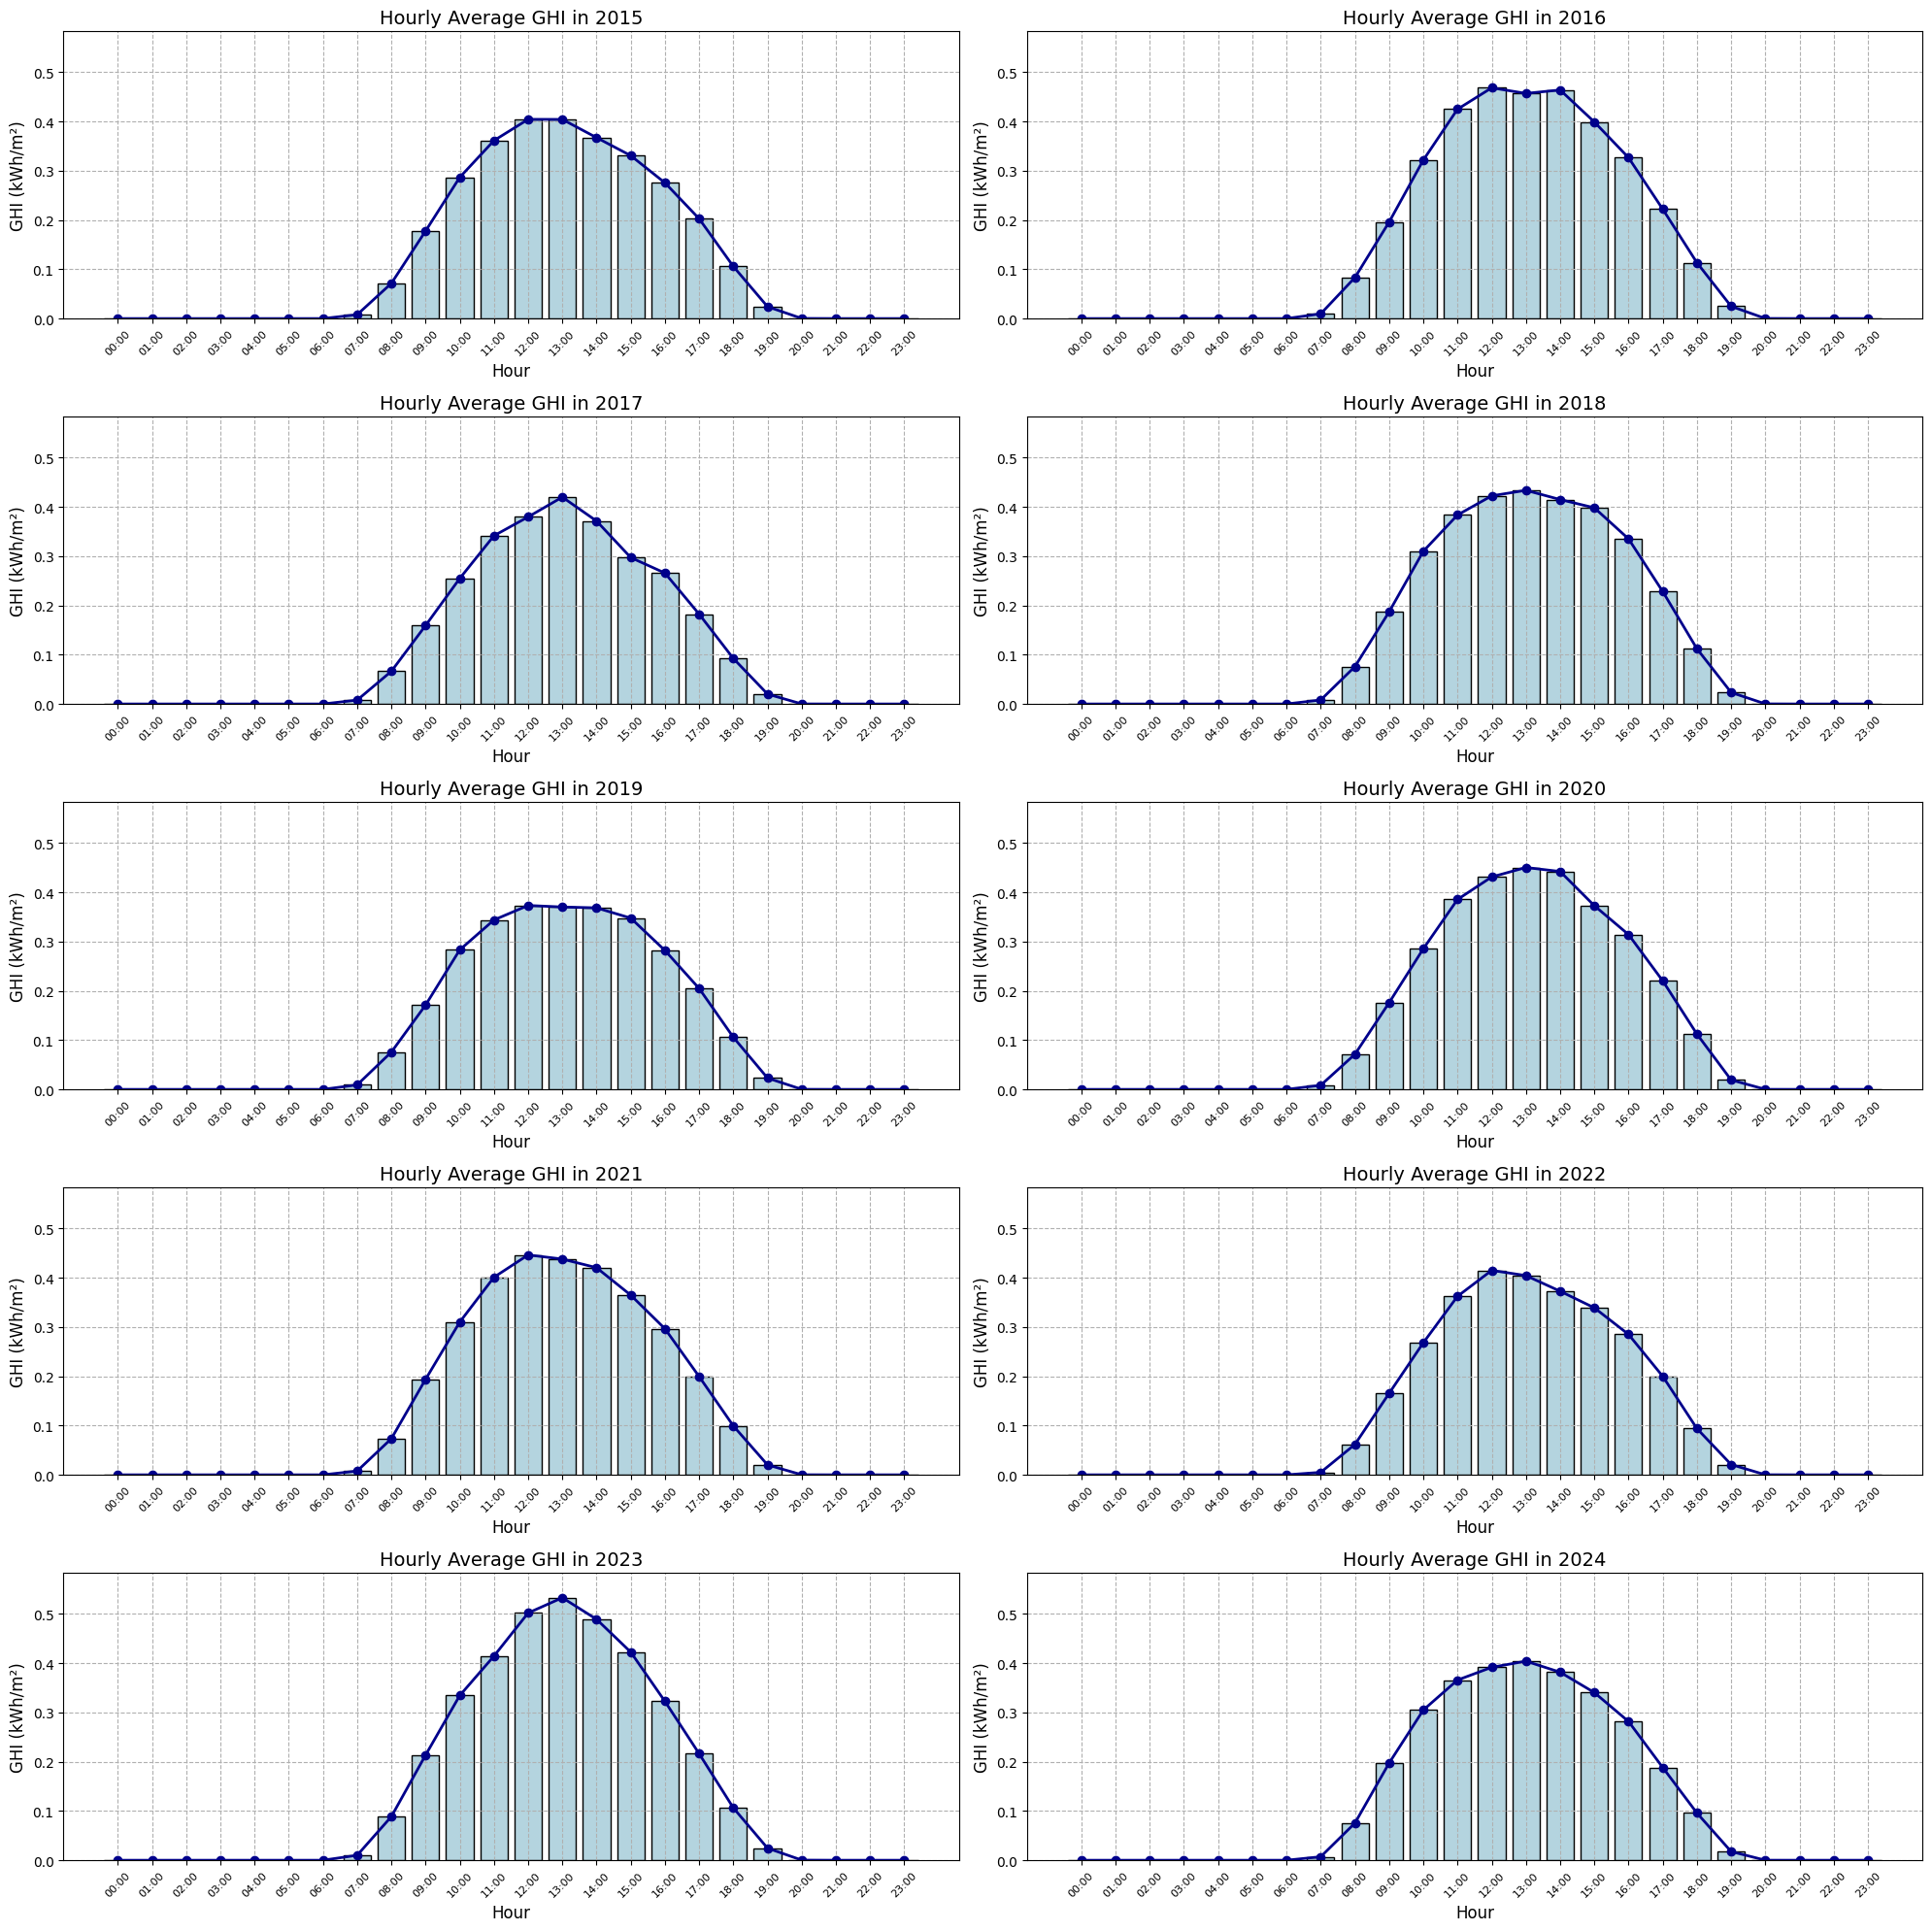

In [35]:
plot_all_years(df)

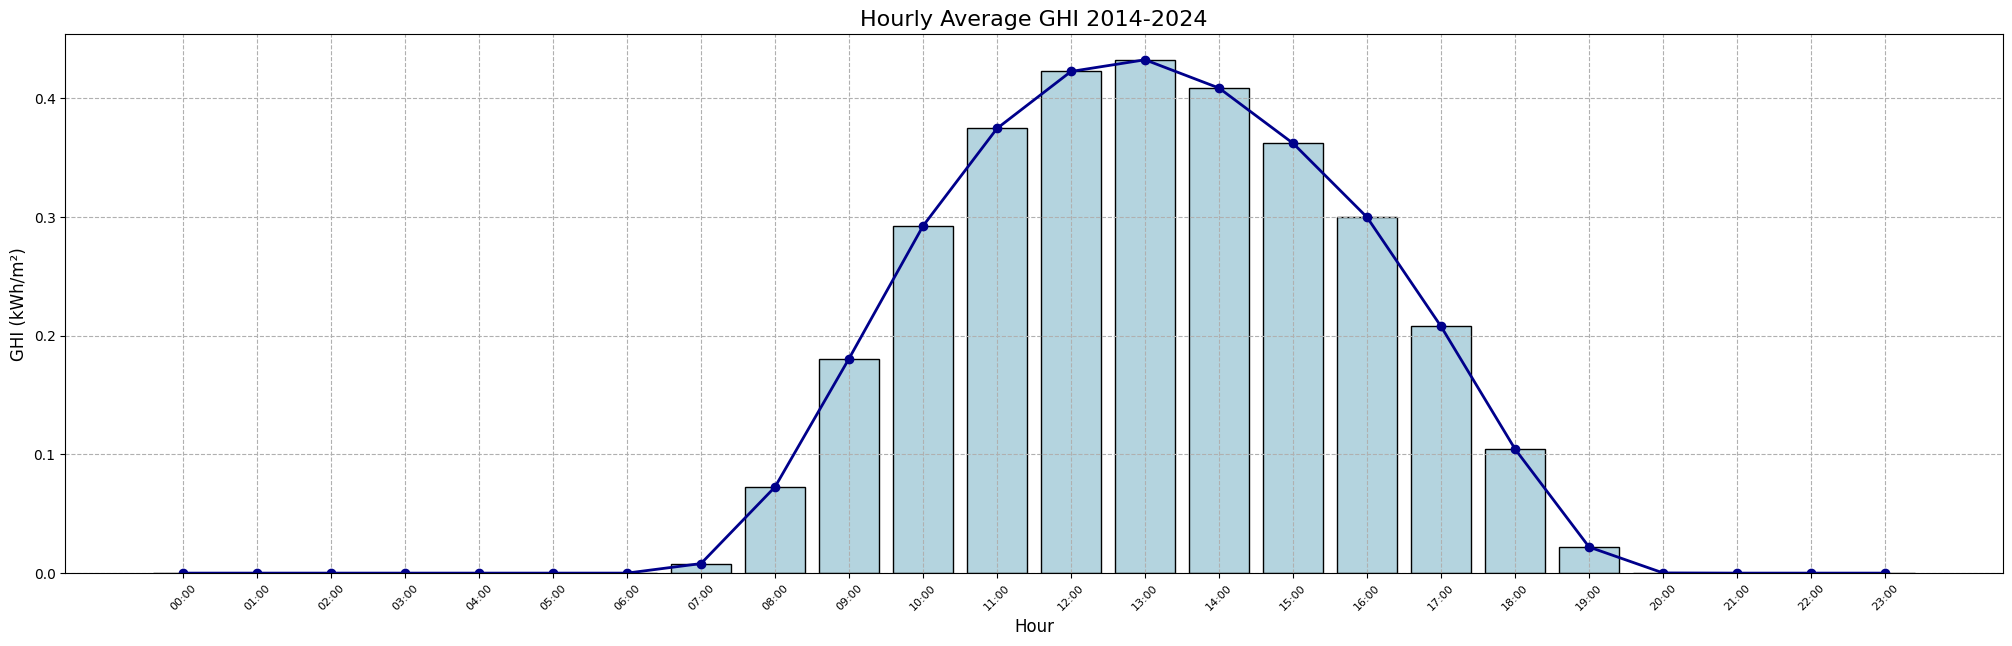

In [36]:
def plot_hourly_mean_ghi_bar(df):
    # Calculate the hourly average GHI
    ghi_avg = df.groupby('hour', observed=False)['ghi'].mean().reset_index()

    # Create a bar plot
    plt.figure(figsize=(25, 7))
    sns.barplot(data=ghi_avg, x='hour', y='ghi', color='lightblue', edgecolor='black')

    # Overlay a line plot to show the trend
    plt.plot(ghi_avg['hour'], ghi_avg['ghi'], color='darkblue', marker='o', linestyle='-', linewidth=2, markersize=6)

    # Add title and labels
    plt.title('Hourly Average GHI 2014-2024', fontsize=16)
    plt.xlabel('Hour', fontsize=12)
    plt.ylabel('GHI (kWh/m²)', fontsize=12)

    # Add gridlines for better visual separation
    plt.grid(True, linestyle='--')

    # Customize x-ticks to show hours in "HH:MM" format (e.g., "00:00", "01:00")
    xticks = pd.date_range('00:00', '23:00', freq='h').strftime('%H:%M')
    plt.xticks(range(24), labels=xticks, fontsize=8, rotation=45)

    plt.show()

plot_hourly_mean_ghi_bar(df)


In [37]:
def plot_hourly_ghi_distribution(df):
    # Convert 'hour' column to a categorical variable for proper ordering
    df['hour'] = df['hour'].astype('category')

    # Create the Plotly box plot
    fig = px.box(
        df,
        x='hour',
        y='ghi',
        title='Hourly GHI Distribution 2014-2024',
        labels={'hour': 'Hour', 'ghi': 'GHI (kWh/m²)'}
    )

    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Hour',
        yaxis_title='GHI (kWh/m²)',
        title_font_size=16,
        xaxis=dict(tickmode='linear'),
        yaxis=dict(gridcolor='lightgray'),
        plot_bgcolor='white',
    )

    # Show the figure
    fig.show()

In [38]:
plot_hourly_ghi_distribution(df)

In [39]:
# next, ill calculate the mean ghi per day per year
def calculate_daily_avg_ghi_per_year(df, year):
    df_year = df[df['year'] == year]
    ghi_year_avg = df_year.groupby(['month', 'day'])['ghi'].mean().reset_index()
    # change kwh/m^2 to be kwh/m^2/day
    ghi_year_avg['ghi'] = ghi_year_avg['ghi'] * 24
    return ghi_year_avg

In [40]:
def plot_daily_avg_ghi_per_year(ghi_avg, year, ax, y_limits):
    # Plotting the bar chart on the specific axis (ax)
    sns.barplot(data=ghi_avg, x=ghi_avg['day'], y='ghi', color='lightblue', edgecolor='black', ax=ax)

    # Adding title and labels
    ax.set_title(f'Daily Average GHI in {year}', fontsize=14)
    ax.set_xlabel('Day (september-october)', fontsize=12)
    ax.set_ylabel('GHI (kWh/m²)', fontsize=12)

    # Adding gridlines for better visual separation
    ax.grid(True, linestyle='--')

    # Customizing x-ticks to show each day from `ghi_avg`
    ax.set_xticks(range(len(ghi_avg['day'])))
    ax.set_xticklabels(ghi_avg['day'].astype(str), fontsize=10)

    # Setting the same Y-axis scale for all subplots
    ax.set_ylim(y_limits)

In [41]:
def plot_all_years_daily(df, start_year=2015, end_year=2024):
    # Create a 5x2 grid of subplots for years 2015 to 2024
    fig, axes = plt.subplots(5, 2, figsize=(20, 20))  # 5 rows, 2 columns
    axes = axes.flatten()  # Flatten to easily index the axes

    # Determine the global Y-axis limits across all years
    global_min = float('inf')
    global_max = float('-inf')

    for year in range(start_year, end_year + 1):
        ghi_avg = calculate_daily_avg_ghi_per_year(df, year)
        global_min = min(global_min, ghi_avg['ghi'].min())
        global_max = max(global_max, ghi_avg['ghi'].max() + 0.05)

    y_limits = (global_min, global_max)

    for i, year in enumerate(range(start_year, end_year + 1)):
        # Calculate the hourly average for each year
        ghi_avg = calculate_daily_avg_ghi_per_year(df, year)
        # Plot the hourly average GHI for the specific year on the subplot
        plot_daily_avg_ghi_per_year(ghi_avg, year, axes[i], y_limits)

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.show()

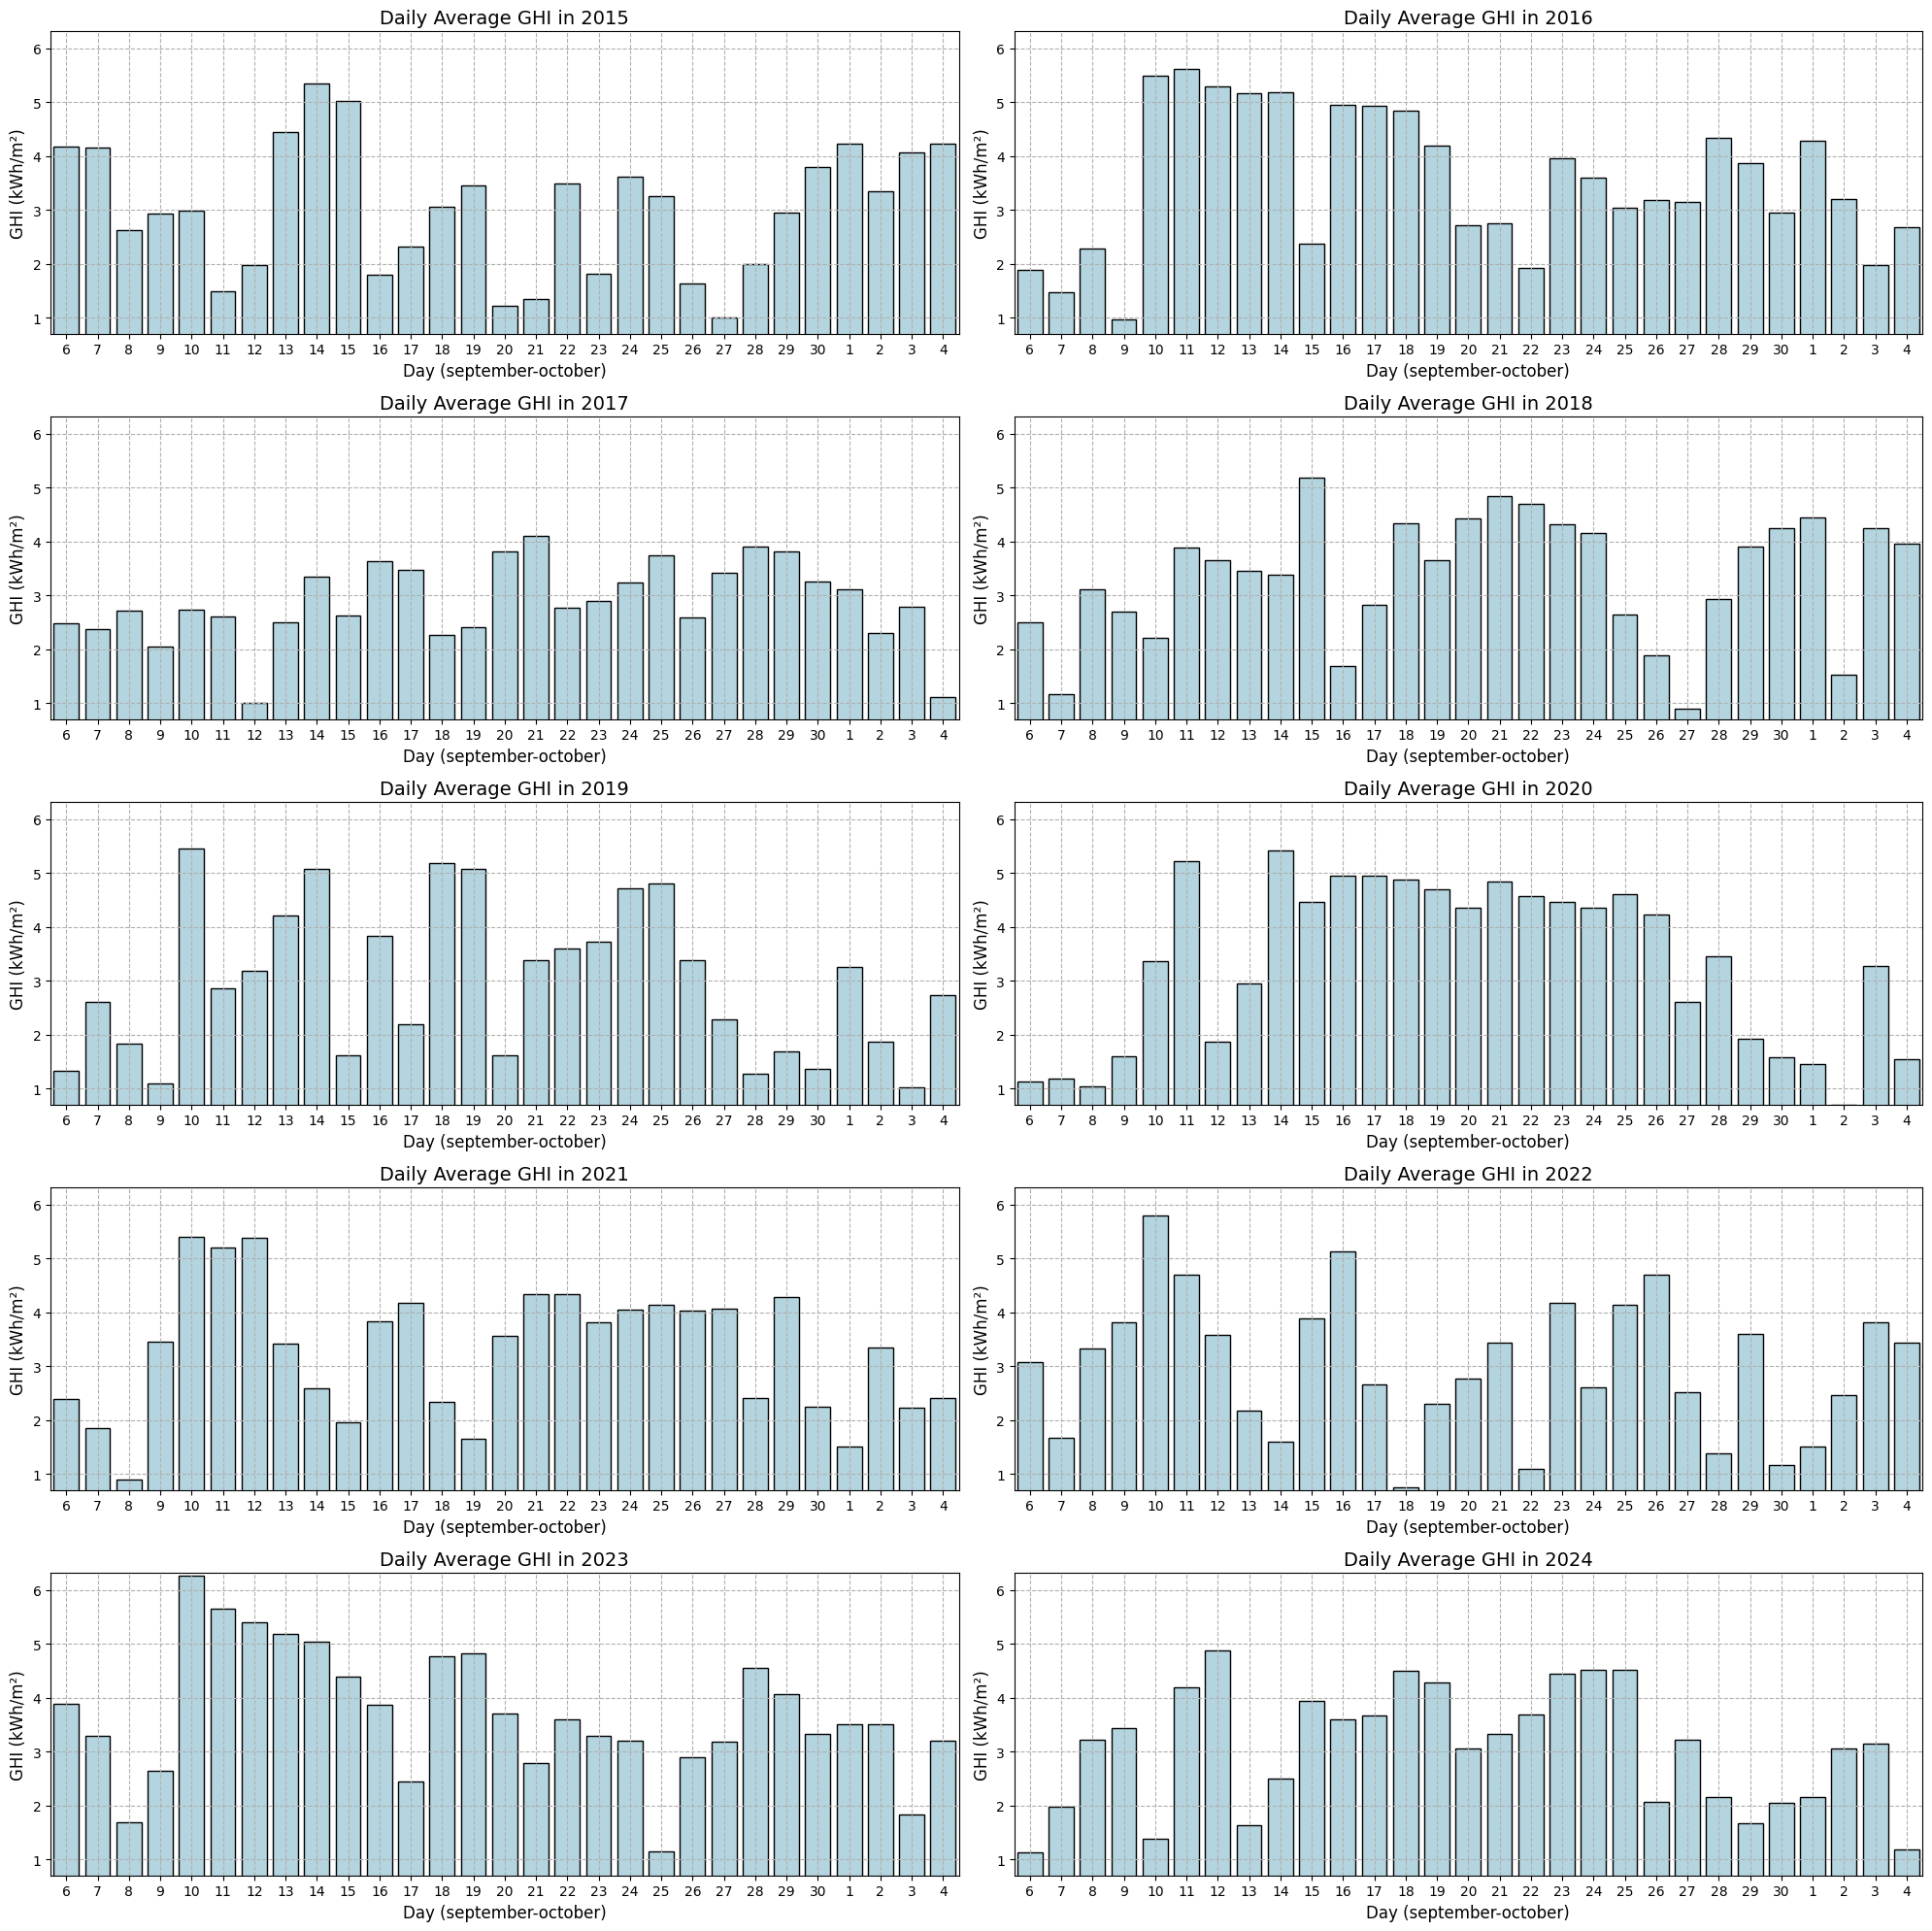

In [42]:
plot_all_years_daily(df)

In [43]:
def calculate_daily_avg_ghi(df):
    ghi_avg = df.groupby(['year', 'month', 'day'])['ghi'].mean().reset_index()
    # change kwh/m^2 to be kwh/m^2/day
    ghi_avg['ghi'] = ghi_avg['ghi'] * 24
    return ghi_avg

In [44]:
def plot_all_years_daily_avg_ghi(df):
    ghi_avg = calculate_daily_avg_ghi(df)
    fig = px.box(
        ghi_avg,
        x='year',
        y='ghi',
        title='Daily Average GHI Distribution 2014-2024',
        labels={'year': 'Year', 'ghi': 'GHI (kWh/m²)'}
    )
    
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='GHI (kWh/m²)',
        title_font_size=16,
        xaxis=dict(tickmode='linear'),
        yaxis=dict(gridcolor='lightgray'),
        plot_bgcolor='white',
    )

    fig.show()

In [45]:
plot_all_years_daily_avg_ghi(df)

In [46]:
def calculate_avg_cload_opacity_24h_distribution(df):
    cloud_avg = df.groupby(['hour', 'month', 'day'], observed=False)['cloud_opacity'].mean().reset_index()
    return cloud_avg

In [47]:
def plot_avg_cload_opacity_24h_distribution():
    cloud_avg = calculate_avg_cload_opacity_24h_distribution(df)
    fig = px.box(
        cloud_avg,
        x='hour',
        y='cloud_opacity',
        title='24-Hour Average Cloud Opacity Distribution 2014-2024',
        labels={'hour': 'Hour', 'cloud_opacity': 'Cloud Opacity (%)'}
    )

    fig.update_layout(
        xaxis_title='Hour',
        yaxis_title='Cloud Opacity (%)',
        title_font_size=16,
        xaxis=dict(tickmode='linear'),
        yaxis=dict(gridcolor='lightgray'),
        plot_bgcolor='white',
    )

    fig.show()

In [48]:
plot_avg_cload_opacity_24h_distribution()

Wind rose diagram (frequency of wind direction and speed)

In [49]:
def create_wind_rose(df):
    # Copy relevant columns
    wind_rose = df[['wind_direction_10m', 'wind_speed_10m', 'month', 'day']].copy()
    # show wind_rose only between 16 to 22 september

    # Create wind direction categories in intervals of 20°
    wind_rose['wind_direction_10m'] = pd.cut(
        wind_rose['wind_direction_10m'],
        bins=range(0, 361, 20),  # 0° to 360° in intervals of 20°
        labels=[f'{i}-{i+20}°' for i in range(0, 360, 20)]
    )

    # Calculate the mean wind speed and the count (frequency) for each wind direction category
    wind_rose_avg = wind_rose.groupby('wind_direction_10m', observed=False).agg(
        wind_speed_avg=('wind_speed_10m', 'mean'),
        wind_direction_count=('wind_speed_10m', 'count')
    ).reset_index()

    fig = px.bar_polar(
        wind_rose_avg,
        r='wind_speed_avg',  # Mean wind speed
        theta='wind_direction_10m',
        title='Wind Rose 2014-2024',
        labels={'wind_speed_avg': 'Wind Speed (m/s)', 'wind_direction_10m': 'Wind Direction (°)'},
        color='wind_direction_count',  # Use count to represent frequency
        color_continuous_scale='Viridis',
        direction='clockwise'
    )

    # Update layout for better aesthetics
    fig.update_layout(
        polar=dict(radialaxis=dict(gridcolor='lightgray')),
        showlegend=True,
        width=1000,
        height=600,
    )

    # Show the figure
    fig.show()

In [50]:
create_wind_rose(df)

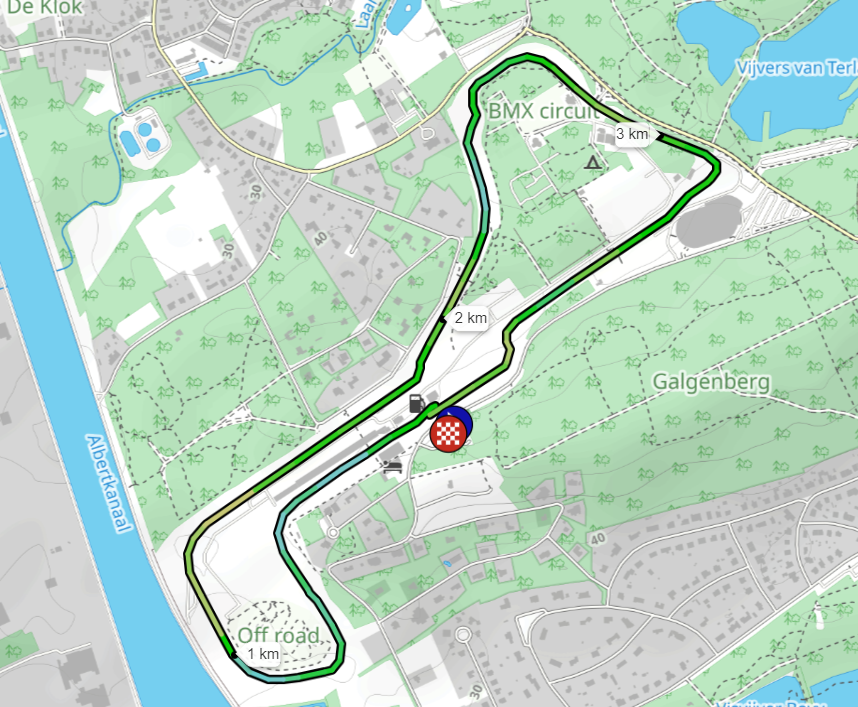

In [51]:
def plot_hourly_mean_air_temp_bar(df):
    # Calculate the hourly average air temperature
    air_temp_avg = df.groupby(['hour'], observed=False)['air_temp'].mean().reset_index()

    # Create a bar plot
    plt.figure(figsize=(20, 10))
    sns.barplot(data=air_temp_avg, x='hour', y='air_temp', color='lightblue', edgecolor='black')

    # Overlay a line plot to show the trend
    plt.plot(air_temp_avg['hour'], air_temp_avg['air_temp'], color='darkblue', marker='o', linestyle='-', linewidth=2, markersize=6)

    # Add title and labels
    plt.title('Hourly Average Air Temperature 2014-2024', fontsize=16)
    plt.xlabel('Hour', fontsize=12)
    plt.ylabel('Air Temperature (°C)', fontsize=12)

    # Add gridlines for better visual separation
    plt.grid(True, linestyle='--')

    # Customize x-ticks to show hours in "HH:MM" format (e.g., "00:00", "01:00")
    xticks = pd.date_range('00:00', '23:00', freq='h').strftime('%H:%M')
    plt.xticks(range(24), labels=xticks, fontsize=8, rotation=45)

    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



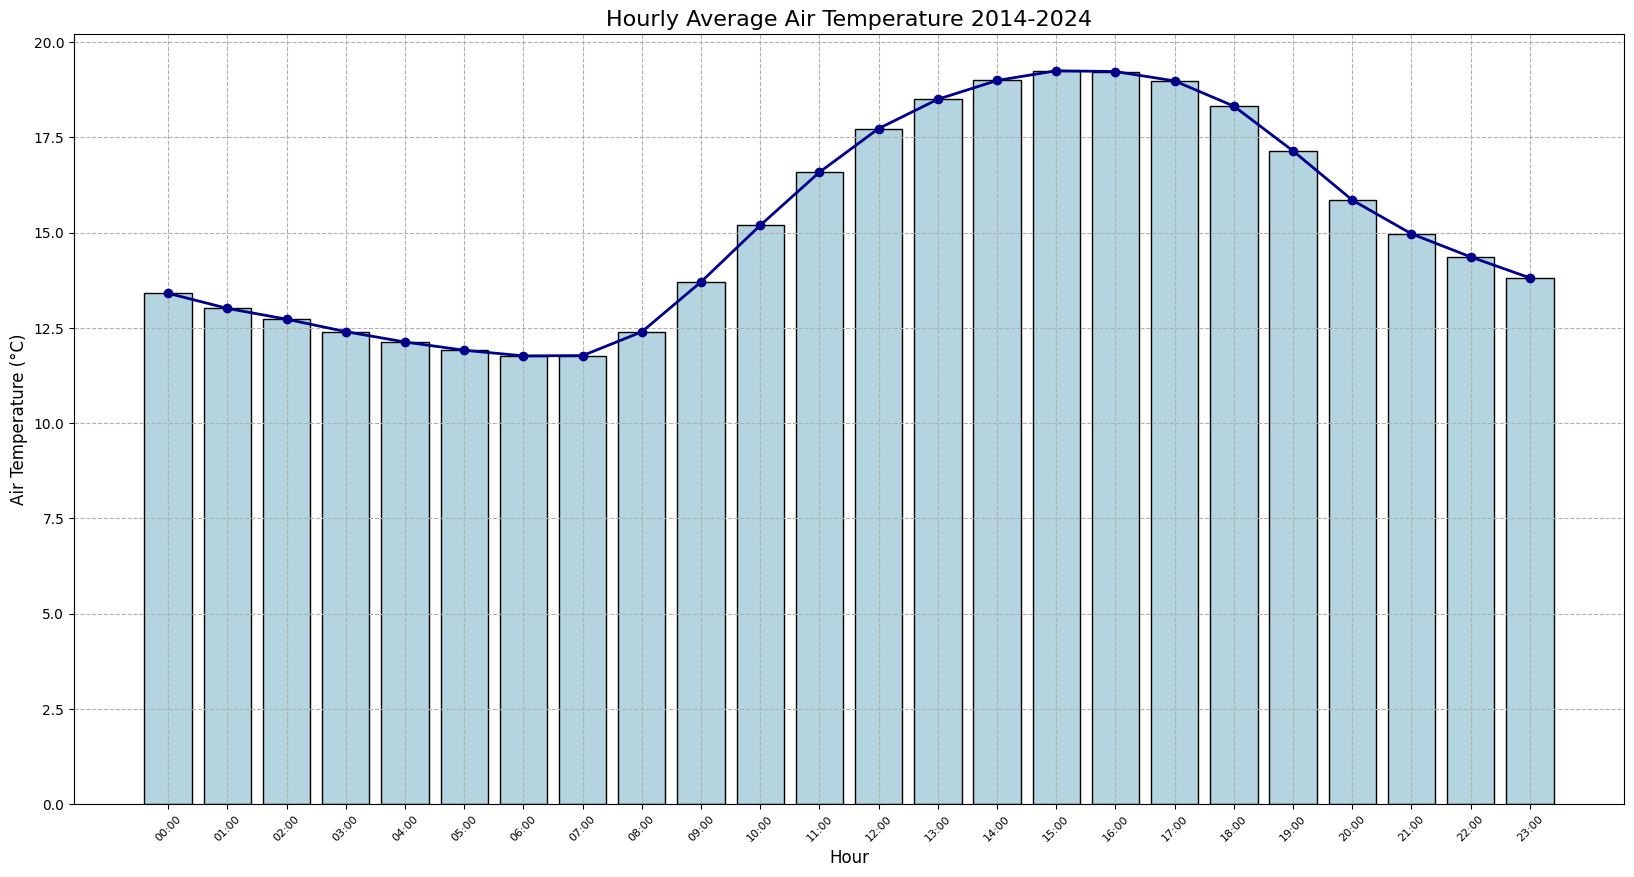

In [52]:
plot_hourly_mean_air_temp_bar(df)

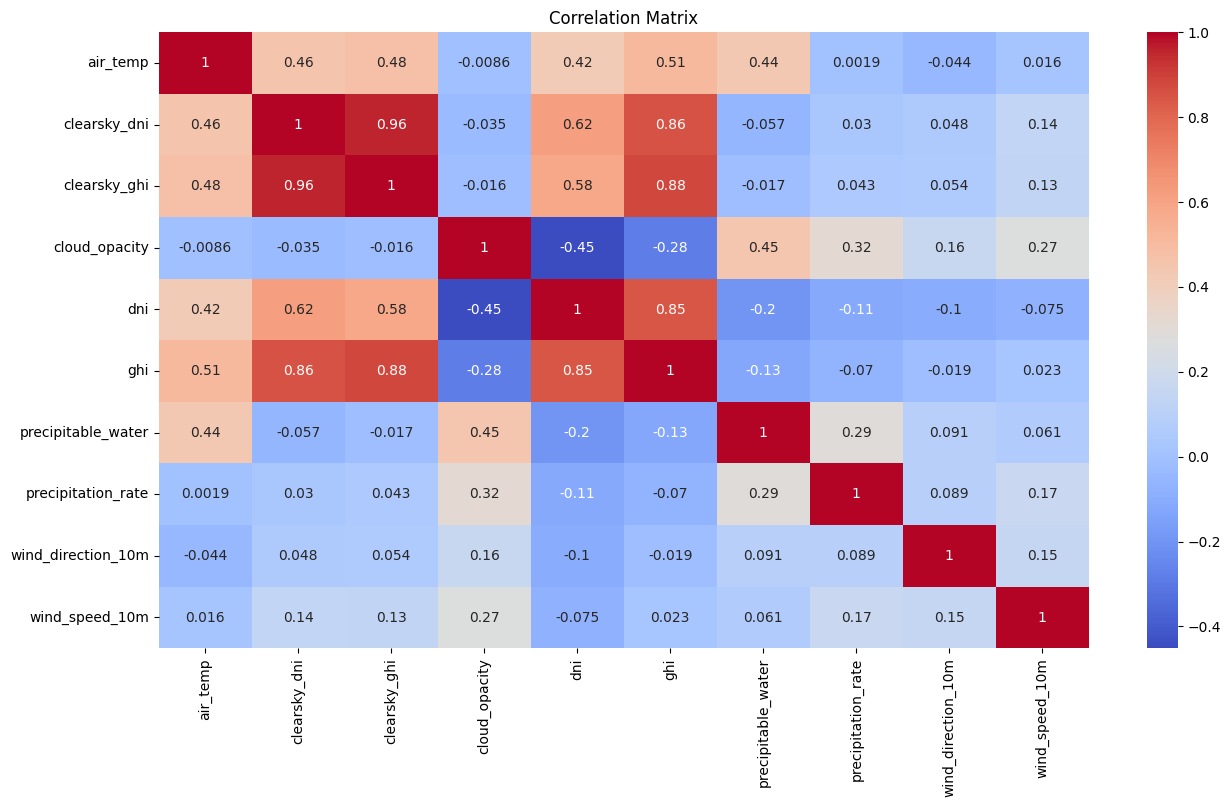

In [53]:
# Exclude date feature
numerical_df = df.select_dtypes(include=['float64', 'int64'])
numerical_df = numerical_df.drop(columns=['year', 'month', 'day', 'minute'])
corr_matrix = numerical_df.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

Main insights from the correlation matrix: 
1. GHI has 0.51 correlation with air_temp 
2. There is weak negative correlation between cloud_opacity and GHI (-0.28) 

## LSTM model building in order to predict a 24h GHI distribution (per 5 minutes)

In [54]:
df.describe()

,air_temp,clearsky_dni,clearsky_ghi,cloud_opacity,dni,ghi,precipitable_water,precipitation_rate,wind_direction_10m,wind_speed_10m,minute,year,month,day
count,91597.000000,91597.000000,91597.000000,91597.000000,91597.000000,91597.000000,91597.000000,91597.000000,91597.000000,91597.00000,91597.000000,91597.000000,91597.000000,91597.000000
mean,15.181676,306.192212,191.831239,31.178769,136.199777,0.133255,22.632511,0.098948,187.769851,3.22522,27.503303,2019.000000,9.138345,15.891678
std,4.486479,343.201828,240.522779,31.968505,262.616274,0.191502,6.828513,0.362544,84.607624,1.62036,17.258762,3.162295,0.345264,8.572979
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.00000,0.000000,2014.000000,9.000000,1.000000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.400000,0.000000,124.000000,2.00000,15.000000,2016.000000,9.000000,9.000000
50%,15.000000,11.000000,9.000000,23.100000,0.000000,0.004000,21.600000,0.000000,206.000000,2.90000,30.000000,2019.000000,9.000000,16.000000
75%,18.000000,685.000000,419.000000,58.400000,82.000000,0.222000,27.000000,0.000000,243.000000,4.10000,45.000000,2022.000000,9.000000,23.000000
max,34.000000,910.000000,730.000000,97.000000,910.000000,0.729000,50.000000,6.900000,360.000000,11.30000,55.000000,2024.000000,10.000000,30.000000


In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
class WeatherPredictor:
    def __init__(self, df):
        """
        Initialize the weather predictor with dataset and configure GPU
        """
        self.df = df
        self.scalers = {}
        self.lstm_model = None
        
        # Configure GPU memory growth
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                print(f"GPU(s) detected: {len(gpus)}")
                print("Using GPU for training")
            except RuntimeError as e:
                print(f"GPU configuration error: {e}")
        else:
            print("No GPU detected. Using CPU for training")
        
    def prepare_data_for_lstm(self, target_variable, sequence_length=24, forecast_horizon=24):
        """
        Prepare data for LSTM model with multi-variable input
        """
        features = ['ghi', 'clearsky_ghi', 'dni', 'clearsky_dni', 'air_temp']
        data = self.df[features].copy()
        
        # Scale the data
        for feature in features:
            self.scalers[feature] = MinMaxScaler()
            data[feature] = self.scalers[feature].fit_transform(data[feature].values.reshape(-1, 1))
        
        X, y = [], []
        target_scaler = self.scalers[target_variable]
        
        for i in range(len(data) - sequence_length - forecast_horizon + 1):
            X.append(data[i:(i + sequence_length)].values)
            y.append(data[target_variable][i + sequence_length:i + sequence_length + forecast_horizon])
        
        X = np.array(X)
        y = np.array(y)
        
        # Convert to TensorFlow tensors
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        
        # Split into train and test sets
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        return (X_train, y_train), (X_test, y_test), target_scaler
    
    def build_lstm_model(self, input_shape, output_length):
        """
        Build and compile LSTM model with mixed precision training
        """
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        
        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=input_shape, dtype='float32'),
            Dropout(0.2),
            LSTM(50, dtype='float32'),
            Dropout(0.2),
            Dense(30, dtype='float32'),
            Dense(output_length, dtype='float32')
        ])
        
        optimizer = Adam(learning_rate=0.001)
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model
    
    def train_lstm(self, target_variable='ghi', sequence_length=96, forecast_horizon=96, epochs=50):
        """
        Train LSTM model for weather prediction with GPU acceleration
        """
        print(f"\nTraining LSTM model for {target_variable} prediction...")
        
        (X_train, y_train), (X_test, y_test), target_scaler = self.prepare_data_for_lstm(
            target_variable, sequence_length, forecast_horizon
        )
        
        self.lstm_model = self.build_lstm_model(
            input_shape=(sequence_length, X_train.shape[2]),
            output_length=forecast_horizon
        )
        
        batch_size = 64
        callbacks = [
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=0.0001
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
        ]
        
        history = self.lstm_model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )
        
        train_pred = self.lstm_model.predict(X_train, batch_size=batch_size)
        test_pred = self.lstm_model.predict(X_test, batch_size=batch_size)
        
        # Convert tensors to numpy if needed
        if isinstance(train_pred, tf.Tensor):
            train_pred = train_pred.numpy()
        if isinstance(test_pred, tf.Tensor):
            test_pred = test_pred.numpy()
        if isinstance(y_train, tf.Tensor):
            y_train = y_train.numpy()
        if isinstance(y_test, tf.Tensor):
            y_test = y_test.numpy()
        
        train_pred = target_scaler.inverse_transform(train_pred)
        test_pred = target_scaler.inverse_transform(test_pred)
        y_train_orig = target_scaler.inverse_transform(y_train)
        y_test_orig = target_scaler.inverse_transform(y_test)
        
        train_rmse = np.sqrt(mean_squared_error(y_train_orig, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_pred))
        
        print(f"Train RMSE: {train_rmse:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}")
        
        return history, (train_pred, test_pred)
    
    def make_future_predictions(self, steps=288):
        """
        Make future predictions using trained LSTM model
        """
        if self.lstm_model is None:
            raise ValueError("Model not trained yet")
            
        last_sequence = self.df[['ghi', 'clearsky_ghi', 'dni', 'clearsky_dni', 'air_temp']].iloc[-288:].copy()
        for feature in last_sequence.columns:
            last_sequence[feature] = self.scalers[feature].transform(
                last_sequence[feature].values.reshape(-1, 1)
            )
        
        sequence_tensor = tf.convert_to_tensor(
            last_sequence.values.reshape(1, 288, 5),
            dtype=tf.float32
        )
        prediction = self.lstm_model.predict(sequence_tensor, batch_size=1)
        
        if isinstance(prediction, tf.Tensor):
            prediction = prediction.numpy()
            
        prediction = self.scalers['ghi'].inverse_transform(prediction)
        
        return prediction[0]


Running weather predictions...
GPU(s) detected: 2
Using GPU for training

Training LSTM model for ghi prediction...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/3
911/911 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.0355 - mae: 0.1280 - val_loss: 0.0179 - val_mae: 0.0826 - learning_rate: 0.0010
Epoch 2/3
911/911 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0172 - mae: 0.0870 - val_loss: 0.0175 - val_mae: 0.0801 - learning_rate: 0.0010
Epoch 3/3
911/911 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0156 - mae: 0.0821 - val_loss: 0.0171 - val_mae: 0.0782 - learning_rate: 0.0010
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Train RMSE: 0.09
Test RMSE: 0.09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


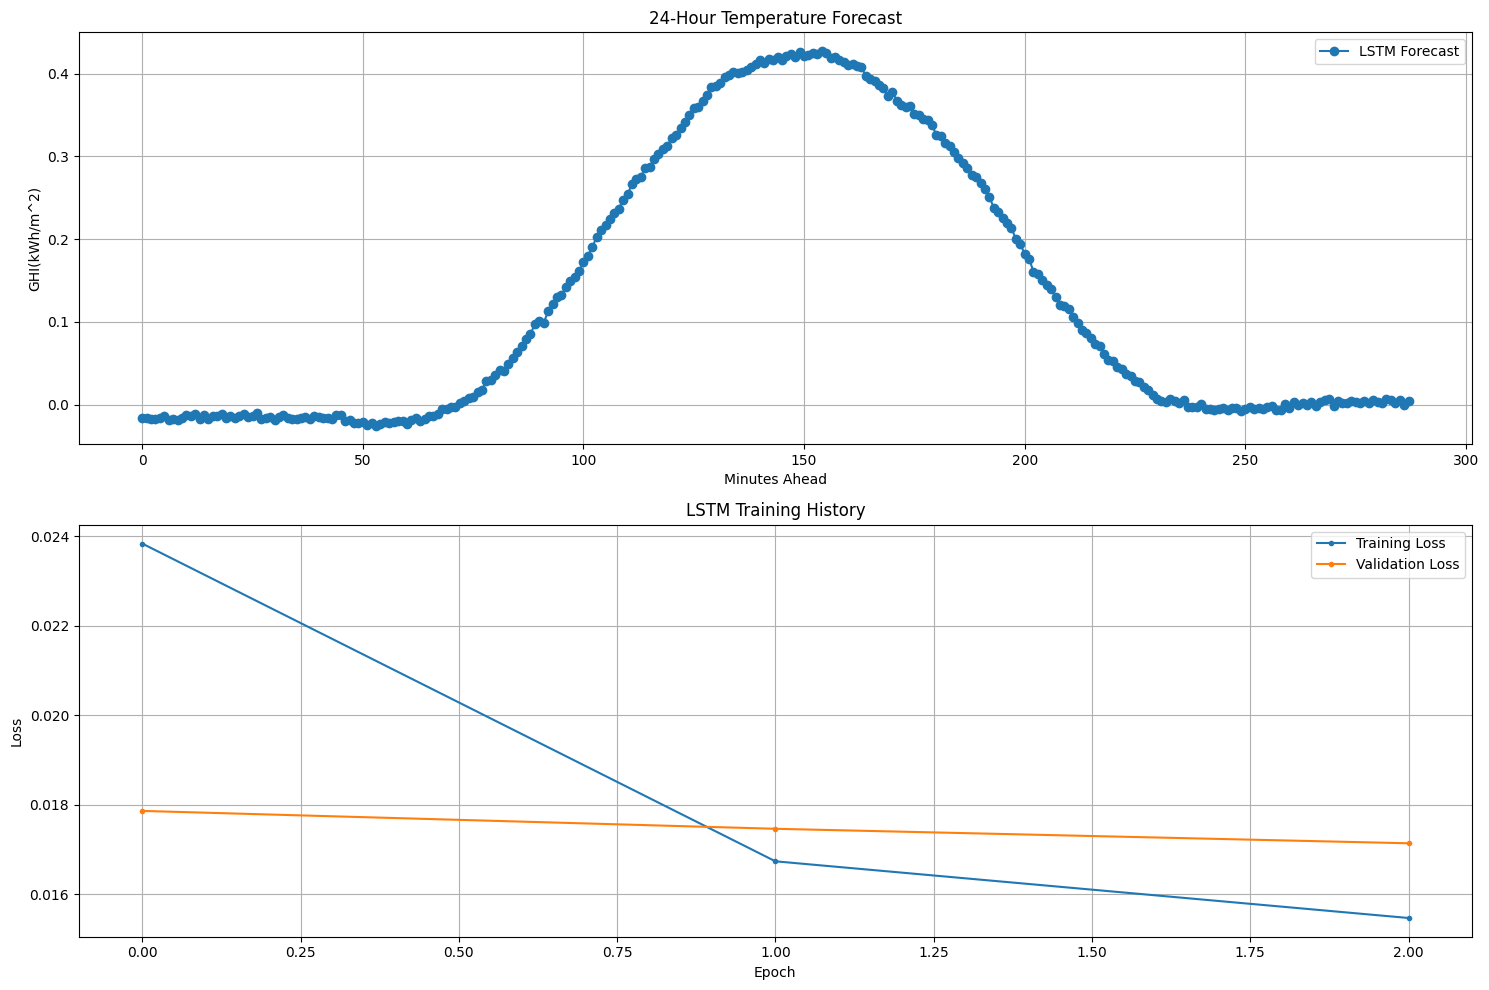

In [37]:
def run_predictions(df):
    """
    Run LSTM predictions with improved plotting
    """
    predictor = WeatherPredictor(df)
    
    # Train and evaluate LSTM
    lstm_history, (lstm_train_pred, lstm_test_pred) = predictor.train_lstm(
        target_variable='ghi',
        sequence_length=288,
        forecast_horizon=288,
        epochs=3
    )
    
    # Make future predictions
    lstm_future = predictor.make_future_predictions(steps=288)

    # Generate 24-hour timestamps (5-minute intervals)
    start_time = pd.Timestamp('00:00:00')  # Start of the day
    time_intervals = [start_time + pd.Timedelta(minutes=5 * i) for i in range(288)]
    time_intervals = [t.strftime('%H:%M') for t in time_intervals]  # Format as HH:MM
    

    # Create a DataFrame for predictions
    predictions_df = pd.DataFrame({
        'Timestamp': predictor.df.index[-len(lstm_future):],
        'LSTM_Forecast': lstm_future
    })
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot forecast
    ax1.plot(range(288), lstm_future, label='LSTM Forecast', marker='o')
    ax1.set_title('24-Hour Temperature Forecast')
    ax1.set_xlabel('5-Minutes 24h distribution')
    ax1.set_ylabel('GHI(kWh/m^2)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss history
    ax2.plot(lstm_history.history['loss'], label='Training Loss', marker='.')
    ax2.plot(lstm_history.history['val_loss'], label='Validation Loss', marker='.')
    ax2.set_title('LSTM Training History')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    
    return predictor, fig


print("\nRunning weather predictions...")
predictor, fig = run_predictions(df)